# Importações

In [2]:
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt
import re

import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# Pré-processamento

In [3]:
dadosMedicos = pd.read_csv(rf'..\2015.csv', sep=';')
dadosMedicos

C:\Users\isabe\AppData\Local\Temp\ipykernel_13044\219197495.py:1: DtypeWarning: Columns (96,97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  dadosMedicos = pd.read_csv(rf'..\2015.csv', sep=';')


,UF_ZI,ANO_CMPT,MES_CMPT,ESPEC,CGC_HOSP,N_AIH,IDENT,CEP,MUNIC_RES,NASC,...,DIAGSEC9,TPDISEC1,TPDISEC2,TPDISEC3,TPDISEC4,TPDISEC5,TPDISEC6,TPDISEC7,TPDISEC8,TPDISEC9
0,120000,2015,1,1,6.360294e+13,1215100018110,1,69900970,120040,19691208,...,NaN,1,0,0,0,0,0,0,0,0
1,120000,2015,1,1,6.360294e+13,1215100018198,1,69900970,120040,19730513,...,NaN,1,0,0,0,0,0,0,0,0
2,120000,2015,1,1,6.360294e+13,1215100018341,1,69921000,120080,19530312,...,NaN,1,0,0,0,0,0,0,0,0
3,120000,2015,1,1,6.360294e+13,1215100018363,1,69900970,120040,19910618,...,NaN,1,0,0,0,0,0,0,0,0
4,120000,2015,1,1,6.360294e+13,1215100018385,1,69960000,120030,19950619,...,NaN,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,110000,2015,2,1,6.074262e+13,1115500004542,1,76900100,110012,19460501,...,NaN,0,0,0,0,0,0,0,0,0
1048571,110000,2015,2,1,6.074262e+13,1115500004553,1,76868000,110013,19560826,...,NaN,0,0,0,0,0,0,0,0,0
1048572,110000,2015,2,1,6.074262e+13,1115500004510,1,76801000,110020,19510602,...,NaN,0,0,0,0,0,0,0,0,0
1048573,110000,2015,2,1,4.287520e+12,1115100053254,1,76801000,110020,19711106,...,NaN,0,0,0,0,0,0,0,0,0


In [4]:
data = dadosMedicos.copy()

# Remover colunas inteiras vazias
data = data.dropna(how='all', axis=1)

# Remover colunas com todos os valores iguais
colunas_com_valores_unicos = data.nunique() == 1
if colunas_com_valores_unicos.any():
    data = data.drop(data.columns[colunas_com_valores_unicos], axis=1)

# # Remover algumas colunas específicas
# data = data.drop(columns=['DIAS_PERM', 'NASC', 'CEP', 'MES_CMPT', 'NATUREZA', 'TPDISEC5', 'DIAR_ACOM', 'SEQUENCIA', 'REMESSA', 'VAL_SH', 'VAL_SP', 'VAL_TOT', 'US_TOT', 'VAL_SH_FED', 'VAL_SP_FED', 'VAL_SH_GES', 'VAL_SP_GES', 'VAL_UCI'])

# Considerar apenas financiamento Faec (04)
mask = data['FINANC'] != 4
data = data.drop(data[mask == True].index)

data = data[['CEP', 'MUNIC_MOV', 'PROC_REA', 'DIAG_PRINC', 'DIAGSEC1', 'DIAGSEC2', 'DIAGSEC3', 'DIAGSEC4', 'MORTE', 'CNES', 'QT_DIARIAS', 'VAL_TOT', 'SEXO', 'IDADE', 'COD_IDADE', 'COMPLEX']]

data = data.rename(columns={"DIAG_PRINC": "DIAGPRINC"})

# # Remover idades zeradas
# mask = data['IDADE'] != 0
# data = data.drop(data[mask == False].index)

#Transformar dados string em numéricos
obj_cols = list(data.select_dtypes(include='object').columns)
data[obj_cols] = data[obj_cols].apply(lambda x: x.str.replace(',','.'))
data['VAL_TOT'] = data['VAL_TOT'].astype(float)

# Preencher células vazias com 0
data = data.fillna(0)

data

,CEP,MUNIC_MOV,PROC_REA,DIAGPRINC,DIAGSEC1,DIAGSEC2,DIAGSEC3,DIAGSEC4,MORTE,CNES,QT_DIARIAS,VAL_TOT,SEXO,IDADE,COD_IDADE,COMPLEX
6,69945000,120040,404010032,J351,W199,0,0,0,0,2001586,2,353.22,3,5,4,2
7,69950000,120040,404010482,J342,W199,0,0,0,0,2001586,1,247.46,3,29,4,2
9,69900970,120040,407020276,K605,W199,0,0,0,0,2001586,1,254.12,1,44,4,2
10,69900970,120040,401020070,L720,W199,0,0,0,0,2001586,1,143.72,3,2,4,2
11,69900970,120040,407030026,K800,W199,0,0,0,0,2001586,2,741.11,3,48,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048569,76801000,110020,405050372,H251,0,0,0,0,0,2807092,1,651.00,1,64,4,3
1048570,76900100,110020,405050372,H251,0,0,0,0,0,2807092,1,651.00,1,68,4,3
1048571,76868000,110020,405050372,H251,0,0,0,0,0,2807092,1,643.00,3,58,4,3
1048572,76801000,110020,405050372,H251,0,0,0,0,0,2807092,1,651.00,1,63,4,3


In [6]:
def encontrar_indice_true(lista):
  for indice, valor in enumerate(lista):
    if valor == True:
      print(colunas_com_valores_unicos.index[indice])


# Exemplo de uso
encontrar_indice_true(colunas_com_valores_unicos)

ANO_CMPT
IDENT
UTI_MES_IN
UTI_MES_AN
UTI_MES_AL
UTI_INT_IN
UTI_INT_AN
UTI_INT_AL
VAL_SADT
VAL_RN
VAL_ACOMP
VAL_ORTP
VAL_SANGUE
VAL_SADTSR
VAL_TRANSP
VAL_OBSANG
VAL_PED1AC
DIAG_SECUN
RUBRICA
CAR_INT
TOT_PT_SP
SEQ_AIH5
CID_ASSO
CID_MORTE
DIAGSEC5
TPDISEC6
TPDISEC7
TPDISEC8
TPDISEC9


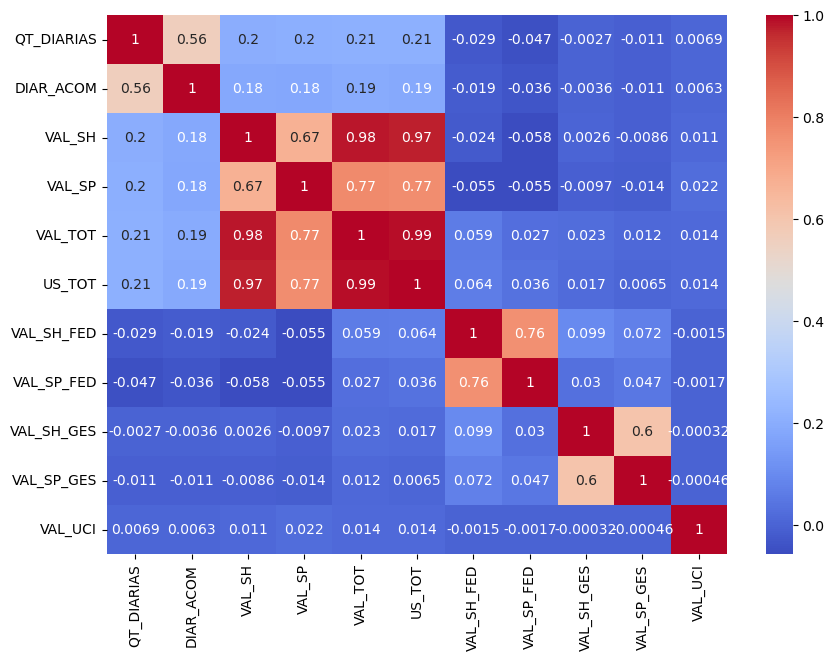

In [7]:
correlacao = dadosMedicos.copy()
correlacao = correlacao[['QT_DIARIAS', 'DIAR_ACOM', 'VAL_SH', 'VAL_SP', 'VAL_TOT', 'US_TOT', 'VAL_SH_FED', 'VAL_SP_FED', 'VAL_SH_GES', 'VAL_SP_GES', 'VAL_UCI']]
correlacao[['VAL_SH', 'VAL_SP', 'VAL_TOT', 'US_TOT', 'VAL_SH_FED', 'VAL_SP_FED', 'VAL_SH_GES', 'VAL_SP_GES', 'VAL_UCI']] = correlacao[['VAL_SH', 'VAL_SP', 'VAL_TOT', 'US_TOT', 'VAL_SH_FED', 'VAL_SP_FED', 'VAL_SH_GES', 'VAL_SP_GES', 'VAL_UCI']].apply(lambda x: x.str.replace(',','.'))
correlacao[['VAL_SH', 'VAL_SP', 'VAL_TOT', 'US_TOT', 'VAL_SH_FED', 'VAL_SP_FED', 'VAL_SH_GES', 'VAL_SP_GES', 'VAL_UCI']] = correlacao[['VAL_SH', 'VAL_SP', 'VAL_TOT', 'US_TOT', 'VAL_SH_FED', 'VAL_SP_FED', 'VAL_SH_GES', 'VAL_SP_GES', 'VAL_UCI']].astype(float)
correlation_matrix = correlacao.corr()

plt.figure(figsize=(10,7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.savefig('imagens/correlation_matrix_removal')
plt.show()


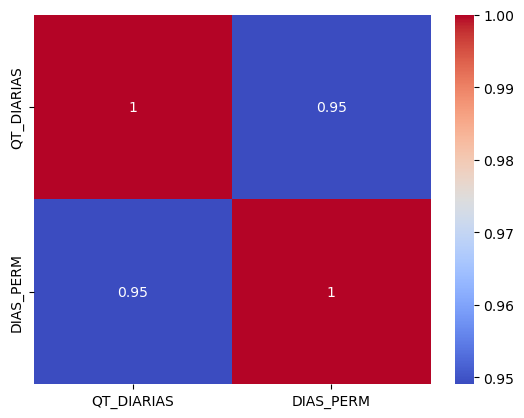

In [8]:
correlacao = dadosMedicos.copy()
correlacao = correlacao[['QT_DIARIAS', 'DIAS_PERM']]
correlation_matrix = correlacao.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.savefig('imagens/correlation_matrix_dias')
plt.show()

In [9]:
data.to_csv(rf'..\2015_dados_selecionados_definitivo.csv')

# Treinamento do modelo

In [ ]:
temp = data.copy()
y = temp['QT_DIARIAS'].copy()

temp = temp.drop(columns=['QT_DIARIAS', 'VAL_TOT', 'MORTE', 'DIAGPRINC', 'DIAGSEC1', 'DIAGSEC2', 'DIAGSEC3', 'DIAGSEC4'])

X = temp.copy()
X = X.astype(float)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# fit model
single_split_model = GaussianNB()
single_split_model.fit(X_train, y_train)

GaussianNB()

In [13]:

cross_val_score(single_split_model, X_test, y_test, cv=10)

d:\Users\isabe\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


array([0.58877964, 0.58747831, 0.58921342, 0.59060014, 0.59103398,
       0.59219089, 0.60202458, 0.59913232, 0.58973247, 0.59002169])

In [14]:
single_split_model.score(X_test, y_test)

0.5985423625873064

# Aplicação de métodos de Machine Learning

In [20]:
temp = data.copy()
y = temp['QT_DIARIAS'].copy()

temp = temp.drop(columns=['QT_DIARIAS', 'VAL_TOT', 'MORTE'])

# Colunas Diagnóstico
colunas = ['DIAGPRINC', 'DIAGSEC1', 'DIAGSEC2', 'DIAGSEC3', 'DIAGSEC4']

# Gera os dummies
dummies = pd.get_dummies(temp[colunas].astype(str))

# Agrupa por valor (ignorando o prefixo da coluna)
dummies.columns = dummies.columns.str.split('_').str[1]

# Faz o OR lógico entre colunas com o mesmo valor (ou seja, se apareceu em qualquer coluna)
dummies = dummies.groupby(level=0, axis=1).max()

# Resultado final (True/False ao invés de 1/0 se quiser)
dummies = dummies.astype(bool)

temp = pd.concat([temp, dummies], axis=1)
# temp = pd.get_dummies(temp)
temp = temp.drop(columns=colunas)
temp = temp.drop(columns=['0'])
X = temp.copy()
X = X.astype(float)

C:\Users\isabe\AppData\Local\Temp\ipykernel_13044\2477159935.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  dummies = dummies.groupby(level=0, axis=1).max()


In [96]:
# dummies.to_csv(rf'..\2015_diagnosticos.csv')

In [16]:
shap_model = DecisionTreeRegressor()
shap_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
explainer = shap.Explainer(shap_model.predict, X_train)
shap_values = explainer(X_train)

ExactExplainer explainer: 161357it [13:17, 200.49it/s]                            


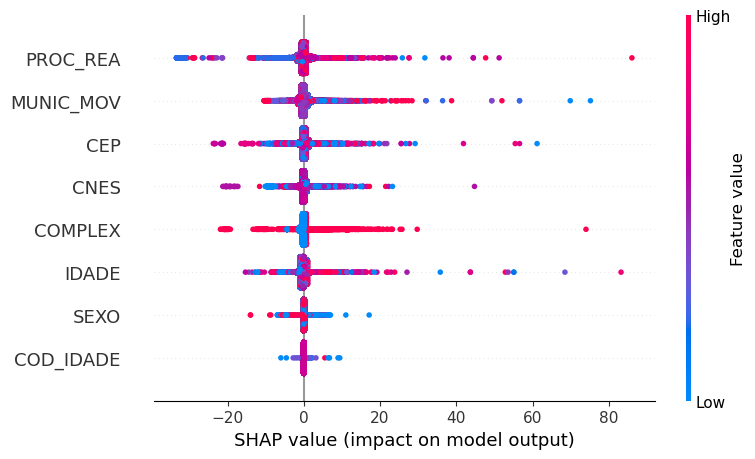

In [18]:
shap.summary_plot(shap_values, X_train)

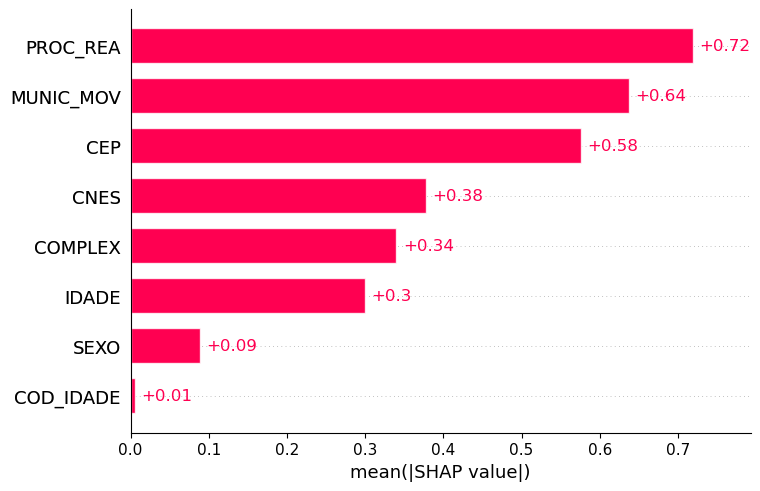

In [19]:
shap.plots.bar(shap_values)

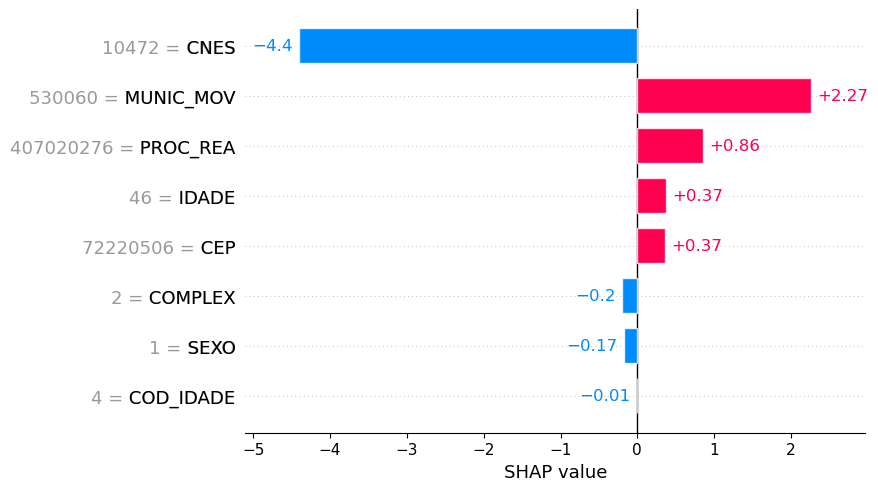

In [20]:
shap.plots.bar(shap_values[0])

In [21]:
explainerNB = shap.Explainer(single_split_model.predict, X_train)
shap_valuesNB = explainerNB(X_train)

ExactExplainer explainer: 161357it [2:06:06, 21.30it/s]                              


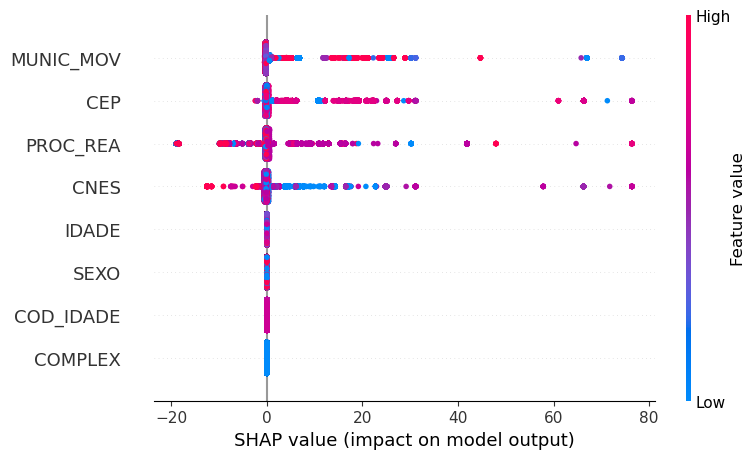

In [22]:
shap.summary_plot(shap_valuesNB, X_train)

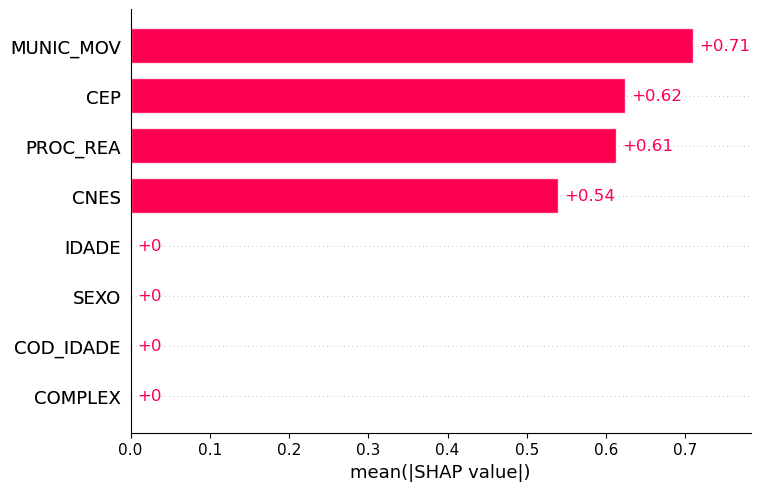

In [23]:
shap.plots.bar(shap_valuesNB)

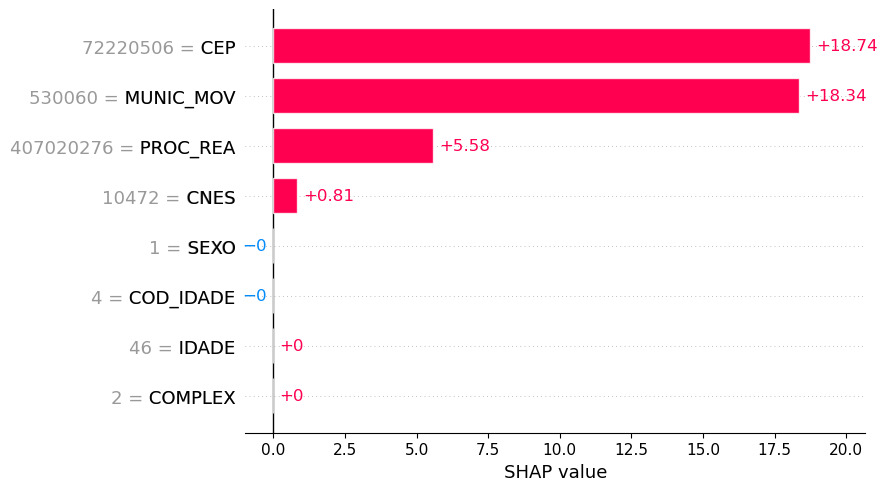

In [24]:
shap.plots.bar(shap_valuesNB[0])

# Avaliando apenas os diagnósticos

In [7]:
diagnosticos = []

for i in list(data['DIAGPRINC'].value_counts().head(50).index):
    diagnosticos.append(str(i))

diagnosticos = list(set(diagnosticos))

In [8]:
dummies_join = dummies[diagnosticos]
dummies_join = pd.concat([dummies_join, y], axis=1)

In [9]:
dummies_join = dummies_join[~dummies_join[diagnosticos].eq(False).all(axis=1)]

In [10]:
y_dummies = dummies_join['QT_DIARIAS']
dummies_join = dummies_join.drop('QT_DIARIAS', axis=1)

In [11]:
dummies_train, dummies_test, y_dummies_train, y_dummies_test = train_test_split(dummies_join, y_dummies, test_size=0.3, random_state=42)

In [12]:
# fit model
single_split_model = DecisionTreeRegressor()
single_split_model.fit(dummies_train, y_dummies_train)
single_split_model.score(dummies_test, y_dummies_test)

0.03813198044318844

In [13]:
# single_split_model = DecisionTreeRegressor()
# single_split_model.fit(dummies_train, y_dummies_train)

explainer = shap.Explainer(single_split_model, dummies_train)
shap_values = explainer(dummies_test, check_additivity=False)

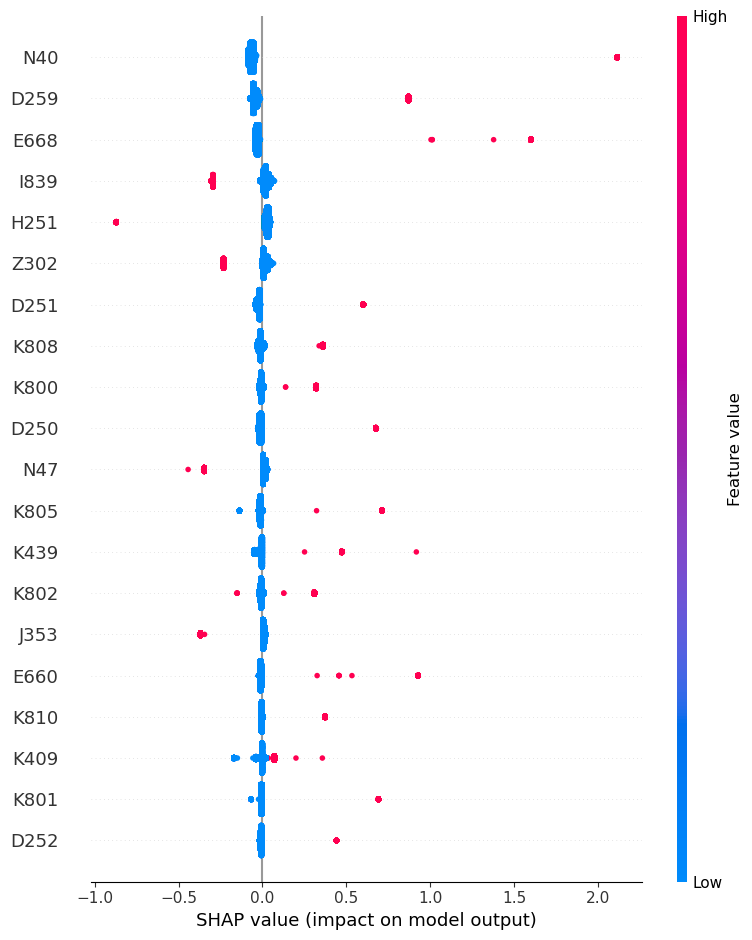

In [14]:
shap.summary_plot(shap_values, dummies_test)

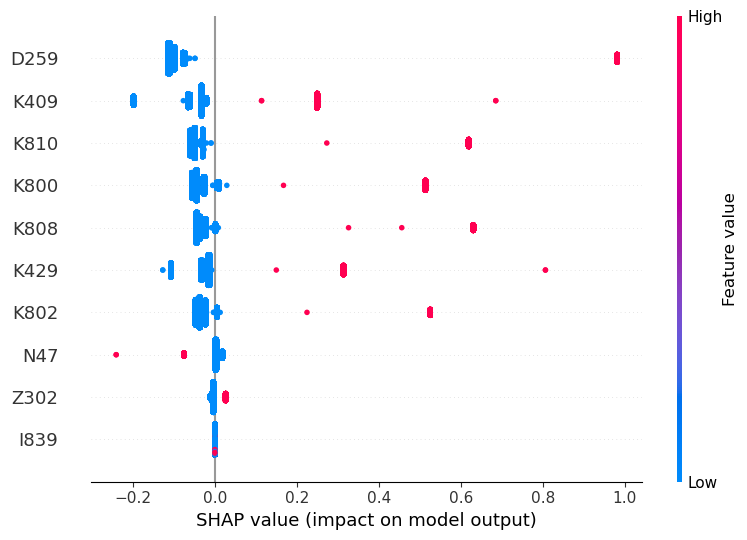

In [108]:
shap.summary_plot(shap_values, dummies_test)

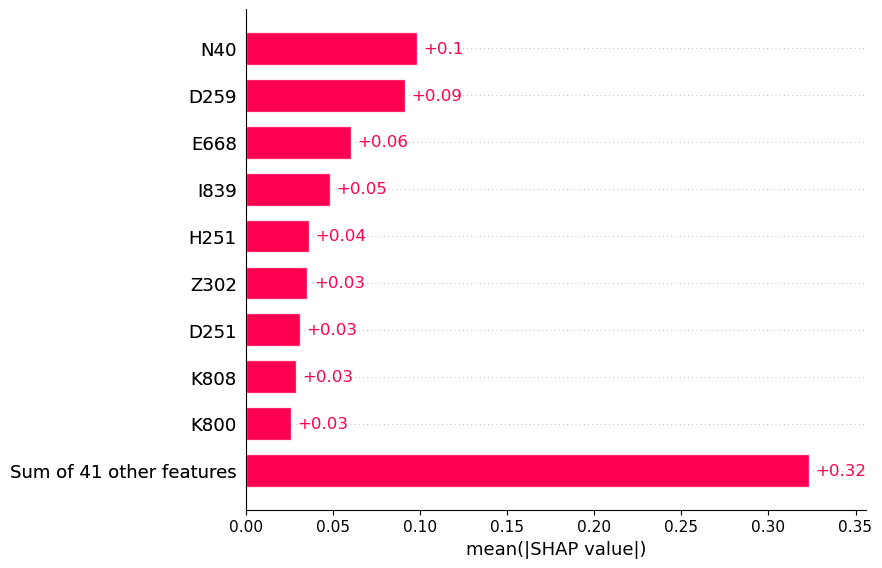

In [15]:
shap.plots.bar(shap_values)

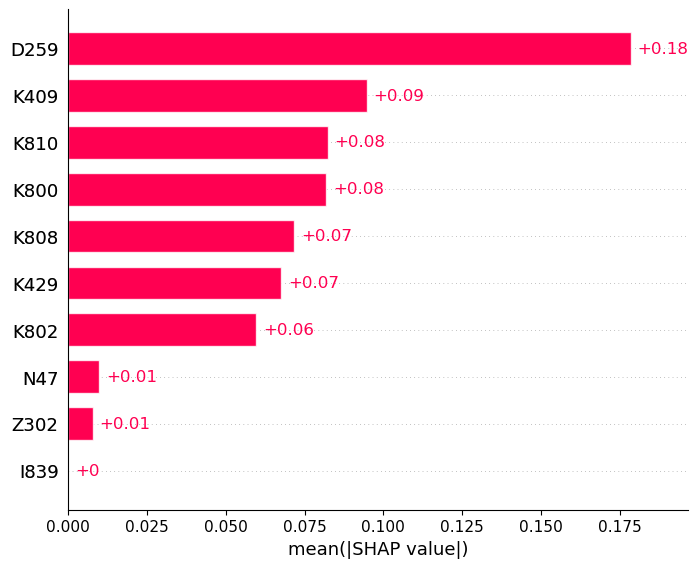

In [ ]:
shap.plots.bar(shap_values)

# Utilizando outras variáveis resposta

## Valor total

In [21]:
temp = data.copy()
y = temp['VAL_TOT'].copy()

temp = temp.drop(columns=['QT_DIARIAS', 'VAL_TOT', 'MORTE', 'DIAGPRINC', 'DIAGSEC1', 'DIAGSEC2', 'DIAGSEC3', 'DIAGSEC4'])

X = temp.copy()
X = X.astype(float)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# fit model
single_split_model = DecisionTreeRegressor()
single_split_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [8]:
cross_val_score(single_split_model, X_test, y_test, cv=10)

array([0.71656094, 0.82430246, 0.67938534, 0.76254839, 0.71088695,
       0.80934288, 0.72979813, 0.70997656, 0.57846238, 0.7508363 ])

In [9]:
single_split_model.score(X_test, y_test)

0.7077766188238692

ExactExplainer explainer: 69154it [05:42, 197.52it/s]                           


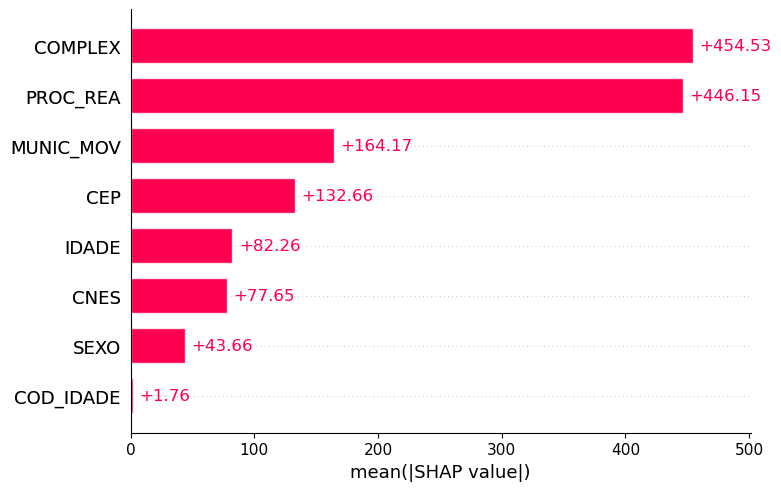

In [11]:
explainer = shap.Explainer(single_split_model.predict, X_train)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

In [12]:
diagnosticos = []

for i in list(data['DIAGPRINC'].value_counts().head(50).index):
    diagnosticos.append(str(i))

diagnosticos = list(set(diagnosticos))

In [22]:
dummies_join = dummies[diagnosticos]
dummies_join = pd.concat([dummies_join, y], axis=1)

In [23]:
dummies_join = dummies_join[~dummies_join[diagnosticos].eq(False).all(axis=1)]

In [24]:
y_dummies = dummies_join['VAL_TOT']
dummies_join = dummies_join.drop('VAL_TOT', axis=1)

In [25]:
dummies_train, dummies_test, y_dummies_train, y_dummies_test = train_test_split(dummies_join, y_dummies, test_size=0.3, random_state=42)

In [26]:
# fit model
single_split_model = DecisionTreeRegressor()
single_split_model.fit(dummies_train, y_dummies_train)
single_split_model.score(dummies_test, y_dummies_test)

0.7577545963758546

PermutationExplainer explainer: 46592it [14:02, 55.33it/s]                           


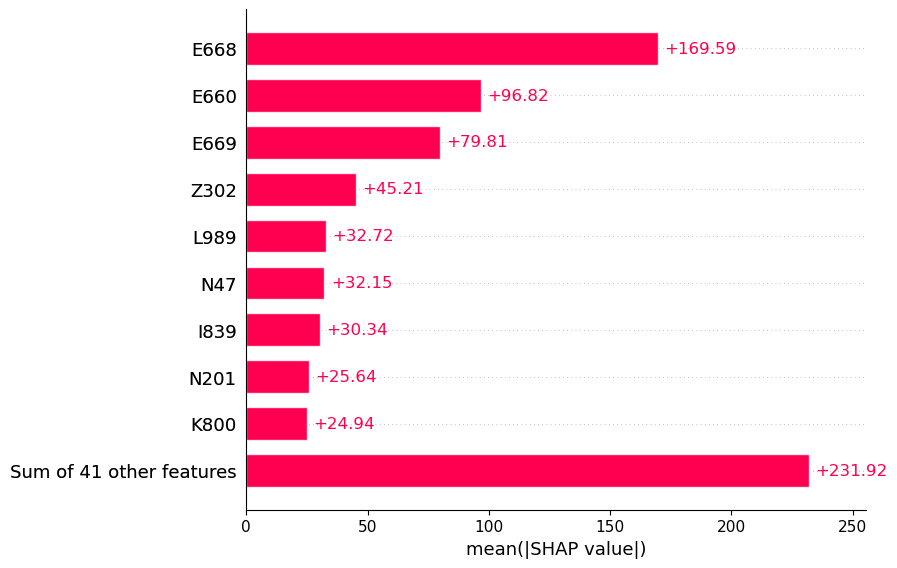

In [27]:
explainer = shap.Explainer(single_split_model.predict, dummies_train)
shap_values = explainer(dummies_test)
shap.plots.bar(shap_values)

## Óbito

In [28]:
temp = data.copy()
y = temp['MORTE'].copy()

temp = temp.drop(columns=['QT_DIARIAS', 'VAL_TOT', 'MORTE', 'DIAGPRINC', 'DIAGSEC1', 'DIAGSEC2', 'DIAGSEC3', 'DIAGSEC4'])

X = temp.copy()
X = X.astype(float)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
# fit model
single_split_model = GaussianNB()
single_split_model.fit(X_train, y_train)

GaussianNB()

In [31]:
cross_val_score(single_split_model, X_test, y_test, cv=10)

array([0.99869867, 0.99869867, 0.99855408, 0.99869848, 0.99869848,
       0.99869848, 0.99869848, 0.99869848, 0.99869848, 0.99869848])

In [32]:
single_split_model.score(X_test, y_test)

0.9986840773357627

ExactExplainer explainer: 69154it [04:56, 225.49it/s]                           


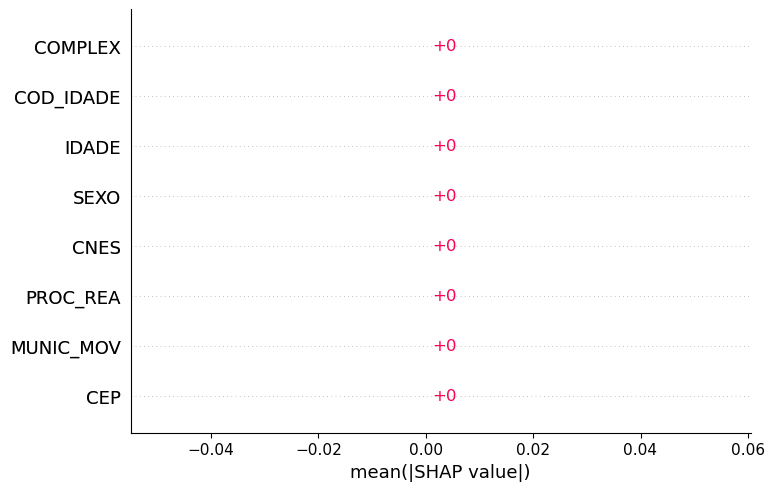

In [33]:
explainer = shap.Explainer(single_split_model.predict, X_train)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

In [34]:
diagnosticos = []

for i in list(data['DIAGPRINC'].value_counts().head(50).index):
    diagnosticos.append(str(i))

diagnosticos = list(set(diagnosticos))

In [35]:
dummies_join = dummies[diagnosticos]
dummies_join = pd.concat([dummies_join, y], axis=1)

In [36]:
dummies_join = dummies_join[~dummies_join[diagnosticos].eq(False).all(axis=1)]

In [37]:
y_dummies = dummies_join['MORTE']
dummies_join = dummies_join.drop('MORTE', axis=1)

In [38]:
dummies_train, dummies_test, y_dummies_train, y_dummies_test = train_test_split(dummies_join, y_dummies, test_size=0.3, random_state=42)

In [39]:
# fit model
single_split_model = GaussianNB()
single_split_model.fit(dummies_train, y_dummies_train)
single_split_model.score(dummies_test, y_dummies_test)

0.4202313751582924

PermutationExplainer explainer: 46592it [14:15, 54.22it/s]                           


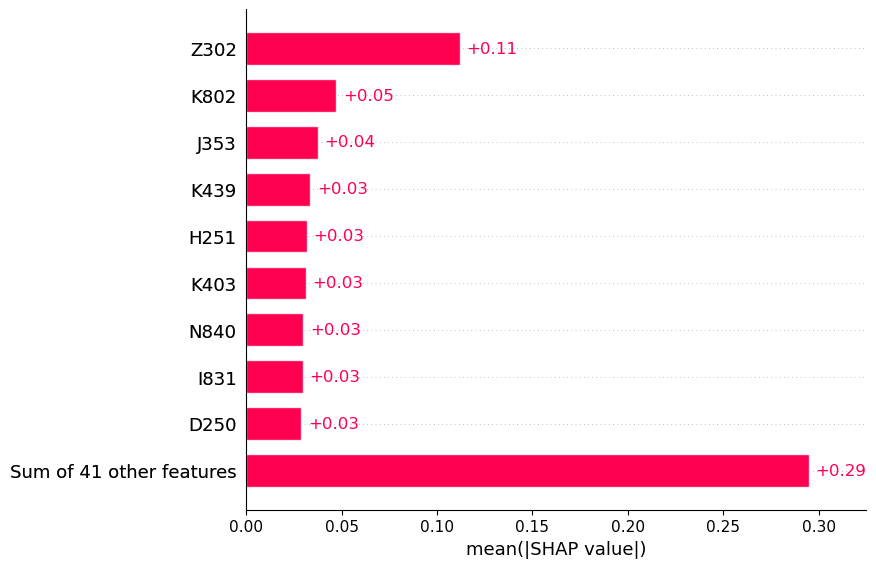

In [46]:
explainer = shap.Explainer(single_split_model.predict, dummies_train)
shap_values = explainer(dummies_test)
shap.plots.bar(shap_values)

# Análise qualitativa

<BarContainer object of 13 artists>

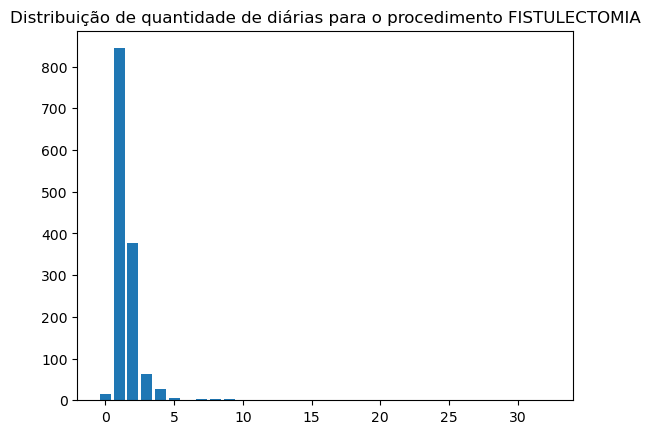

In [ ]:
test = data.loc[data['PROC_REA'] == 407020276]

plt.figure()
plt.title('Distribuição de quantidade de diárias para o procedimento FISTULECTOMIA')
plt.bar(test['QT_DIARIAS'].value_counts().index, test['QT_DIARIAS'].value_counts())